# Contents

In [391]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer


from sklearn import metrics
from sklearn.metrics import mean_squared_error

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, \
    plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score


from sklearn.linear_model import (
    Ridge,RidgeCV,
    Lasso,LassoCV,
    ElasticNet, ElasticNetCV,
    LinearRegression
)
from sklearn.model_selection import(
    cross_val_score,
    train_test_split
)
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures
)
# pd.set_option('display.max_rows', 1000)  # or 1000
pd.set_option('display.max_columns', 50)  # or 1000

from ipywidgets import *
from IPython.display import display

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.pipeline import Pipeline, make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RepeatedStratifiedKFold

from xgboost import XGBClassifier
from xgboost import cv
from xgboost import plot_importance
import xgboost as xgb
use_label_encoder=False

from IPython.display import Markdown as md

# Exploratory Data Analysis

In [3]:
merged_train = pd.read_csv('../data/merged_train.csv')
merged_test = pd.read_csv('../data/merged_test.csv')

In [4]:
# convert date time 
merged_train['date'] = pd.to_datetime(merged_train['date'])
merged_test['date'] = pd.to_datetime(merged_test['date'])

In [5]:
merged_test.shape

(116293, 39)

Text(0.69, 0.5, '5.39% of 8475 observations\nare from the Positive class (1),\nie. WNV present')

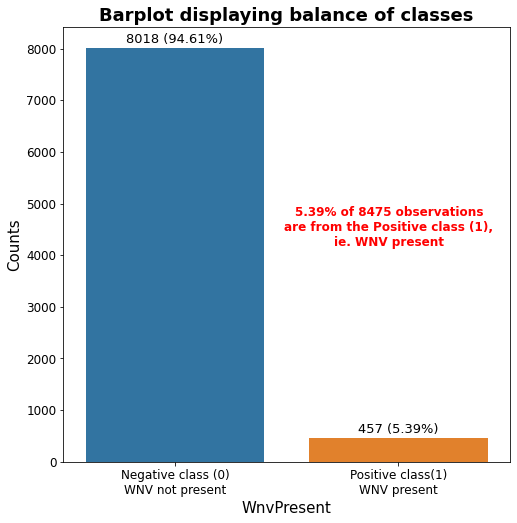

In [6]:
# Plotting the balance of classes on a countplot.

wnv_notpresent = merged_train['wnvpresent'].value_counts()[0]
wnv_present = merged_train['wnvpresent'].value_counts()[1]
neg_pct = merged_train['wnvpresent'].value_counts(normalize=True)[0] * 100
pos_pct = merged_train['wnvpresent'].value_counts(normalize=True)[1] * 100
total = wnv_notpresent + wnv_present

# set up figure size 
plt.figure(figsize=(8,8))

# plot countplot
ax = sns.countplot(x='wnvpresent', data=merged_train)


# set labels for X and y and titles
ax.set_xticklabels(['Negative class (0)\nWNV not present', 'Positive class(1)\nWNV present'])
ax.tick_params(axis='both', labelsize=12)

plt.xlabel("WnvPresent", fontsize=15)
plt.ylabel("Counts", fontsize=15)

plt.title("Barplot displaying balance of classes", fontdict = {'size' : 18, 'weight': 'bold'})

# to plot number of points in each class 
plt.text(x=0, y=wnv_notpresent+100, s=str(wnv_notpresent) + ' (' + str(round(neg_pct,2)) + '%)', fontsize=13, ha='center')
plt.text(x=1, y=wnv_present+100, s=str(wnv_present) + ' (' + str(round(pos_pct,2)) + '%)', fontsize=13, ha='center')

# set up red text 
plt.figtext(x=0.69, 
            y=0.5, 
            s=f"{round(pos_pct, 2)}% of {total} observations\nare from the Positive class (1),\nie. WNV present", 
            fontdict = {'size' : 12, 'weight': 'semibold'},
            ha='center',
            color = 'red',
           )


From the above, we can see that the classes are very unbalanced. Of the 8475 observations, only 457 `(5.5%) are from the positive class` ie. West Nile Virus present (WvvPresent == 1) while 8018 (94.61%) observations from the negative class, ie. West Nile Virus not present (WvvPresent == 0)

We will need to explore ways to balance the two classes before modelling 

# Model Preparation

## Modelling Approaches

As seen from the above, the classes in this case is unbalanced. We will need to deploy balancing techniques like `over-sampling` using imblearn `SMOTE` and also adjust `class_weights` on certain classifiers like RandomForestClassifier. 

We will be using these following models 
- Logistic Regression  
- RandomForestClassifier
- XGboost 

## Classification Matrix

In the context of this project, we define our **positive class as the presence of WNV *(WnvPresent = 1)*, and the negative class as the absence of WNV *(WnvPresent = 0)***.

`Accuracy` is defined as the total number of correct predictions over the total number of predictions made. Essentially, this refers to the correct predictions of mosquitos trapped containing WNV virus over the total number of predictions made.

While `Accuracy` is a good overall measure of the model's performance, a high score doesnt reflect how well it is predicting for each class. For example, having high score, could also mean having very good predictions of mosquitos NOT having WNV (due to high skew of data towards no WnvPresent), that would overshadow class that contains correct predictions for those carrying WNV. 

Hence we need `sensitivity` and `specificity` as well to measure the true positive and true negative rate and achieve balance between the two. 

To answer the part on `calculating the cost involved to deploy the the pesticides` throughout the city of Chicago, having high amount of false positives will result in increased cost for spraying these pesticides. On the other hand, having `large number of false negatives could potentially lead to an outbreak of WNV which would greatly affect the economy should Chicago be forced to take drastic measures to contain it`. Hence, the team has decided it would be better to focus on having `minimal false negatives` than false positives hence leaning towards `sensitivity` than `specificity`. 

### Instantiate X and y variables

In [7]:
merged_train = pd.get_dummies(merged_train, columns = ['species'], drop_first = True)
merged_test = pd.get_dummies(merged_test, columns = ['species'], drop_first = True)

In [8]:
merged_train.columns

Index(['date', 'latitude', 'longitude', 'nummosquitos', 'wnvpresent',
       'wnvcount', 'station', 'tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb',
       'heat', 'cool', 'codesum', 'preciptotal', 'stnpressure', 'sealevel',
       'resultspeed', 'resultdir', 'avgspeed', 'month', 'sunrise', 'sunset',
       'bcfg', 'br', 'dz', 'fg', 'fg+', 'fu', 'hz', 'mifg', 'ra', 'sn', 'sq',
       'ts', 'tsra', 'vcts', 'gr', 'vcfg', 'sprayed', 'species_CULEX PIPIENS',
       'species_CULEX PIPIENS/RESTUANS', 'species_CULEX RESTUANS',
       'species_CULEX SALINARIUS', 'species_CULEX TARSALIS',
       'species_CULEX TERRITANS'],
      dtype='object')

In [9]:
X = merged_train[[col for col in merged_train.columns if (merged_train[col].dtypes !='O') & (col not in ['date','block','addressaccuracy','nummosquitos','wnvcount','wnvpresent', 'station','species_CULEX SALINARIUS',
 'species_CULEX TARSALIS',
 'species_CULEX TERRITANS'])]]
y = merged_train['wnvpresent']

In [10]:
kaggle_test = merged_test[[col for col in merged_test.columns if (merged_test[col].dtypes !='O') & (col not in ['date','block','addressaccuracy', 'station','species_CULEX SALINARIUS',
 'species_CULEX TARSALIS',
 'species_CULEX TERRITANS','species_UNSPECIFIED CULEX'])]]

In [11]:
X.shape

(8475, 38)

In [12]:
kaggle_test.shape

(116293, 38)

Train test split

In [13]:
# Splitting X and y into training and testing datasets.

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [14]:
# Scaling X_train to the standard scale.

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)

# Transforming X_test to the same scale.

X_test_sc = ss.transform(X_test)

In [15]:
# Transforming actual test dataframe to the same scale (to generate predictions for kaggle submission later).

kaggle_test_sc = ss.transform(kaggle_test)

# Classification Modelling

### Class balancing Technique

We will be using only `smote` for this project

In [16]:
# instantiate SMOTE
smote = SMOTE(random_state=42)

In [17]:
X_train_sc_smote, y_train_smote = smote.fit_resample(X_train_sc, y_train)

In [18]:
# Checking the distribution of classes with SMOTE balancing technique.

y_train_smote.value_counts()

0.0    6013
1.0    6013
Name: wnvpresent, dtype: int64

We can see the library helped balance the proportions between two classes. 

`SMOTE` is an over-sampling method, that creates copies of the minority class data points with small variations, making synthetic samples more diverse [source](https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/). Hence we see the number of data points for the positive class matching with the negative class

### Logistic regression & SMOTE

In [19]:
# Creating a pipeline object using imblearn.pipeline with SMOTE and LogisticRegression.

pipe_logreg = make_pipeline(SMOTE(random_state=42),
                      LogisticRegression(penalty='elasticnet', solver='saga', random_state=42, max_iter=1000)
                     )

In [20]:
pipe_logreg.get_params()

{'memory': None,
 'steps': [('smote', SMOTE(random_state=42)),
  ('logisticregression',
   LogisticRegression(max_iter=1000, penalty='elasticnet', random_state=42,
                      solver='saga'))],
 'verbose': False,
 'smote': SMOTE(random_state=42),
 'logisticregression': LogisticRegression(max_iter=1000, penalty='elasticnet', random_state=42,
                    solver='saga'),
 'smote__k_neighbors': 5,
 'smote__n_jobs': None,
 'smote__random_state': 42,
 'smote__sampling_strategy': 'auto',
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 1000,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'elasticnet',
 'logisticregression__random_state': 42,
 'logisticregression__solver': 'saga',
 'logisticre

In [21]:
# {'logisticregression__C': 2.7777777777777777,
#  'logisticregression__l1_ratio': 1}

In [22]:
# Establishing ranges of hyperparameters C and l1_ratio for GridSearchCV, and class_weight.

pipe_logreg_params = {
    'logisticregression__C': [2.77],
    'logisticregression__l1_ratio': [1],
    }

In [23]:
# Creating a GridSearchCV with scoring of ROC_AUC

gs_logreg = GridSearchCV(pipe_logreg, 
                        param_grid=pipe_logreg_params, 
                        cv=5, 
                        scoring='roc_auc',
                        n_jobs = -1
                       )

In [24]:
# Fitting GridSearchCV with SMOTE and LogisticRegression on X_train_sc and y_train.

gs_logreg.fit(X_train_sc, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000,
                                                           penalty='elasticnet',
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [2.77],
                         'logisticregression__l1_ratio': [1]},
             scoring='roc_auc')

In [25]:
gs_logreg.best_params_

{'logisticregression__C': 2.77, 'logisticregression__l1_ratio': 1}

In [26]:
# Scoring model for all matrix 

train_acc = gs_logreg.score(X_train_sc, y_train)
cross_val_acc = gs_logreg.best_score_
test_acc = gs_logreg.score(X_test_sc, y_test)
preds = gs_logreg.predict(X_test_sc)
y_pred_proba = gs_logreg.predict_proba(X_test_sc)

confusion_matrix(y_test, # True values.
                 preds)# Predicted values.
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel();

sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)
roc_auc  = roc_auc_score(y_test, y_pred_proba[:,1])


C:\Users\Admin\.conda\envs\myenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


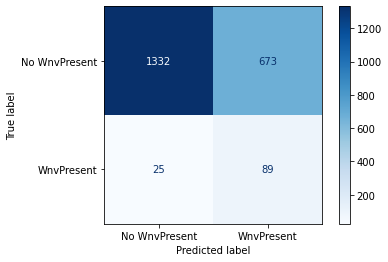

In [27]:
# Plot Confusion matrix
plot_confusion_matrix(gs_logreg, X_test_sc, y_test, cmap='Blues', 
                      values_format='d', display_labels=['No WnvPresent', 'WnvPresent']);                 

In [28]:
summary_df = pd.DataFrame(columns=['Classifier',
                                   'Class Balancing Technique',
                                   'Train Accuracy',
                                   'GridSearchCV Accuracy',
                                   'Actual Test Accuracy',
                                   'Overfit (-ve) / Underfit (+ve)',
                                   'Sensitivity',
                                   'Specificity',
                                   'Precision',
                                   'ROC-AUC',
                                  ])

In [29]:
summary_df.loc[1] = ["LogisticRegression",
                     "SMOTE",
                     round(train_acc, 3),
                     round(cross_val_acc, 3),
                     round(test_acc, 3),
                     round(train_acc-test_acc, 3),
                     round(sensitivity, 3),
                     round(specificity, 3),
                     round(precision, 3),
                     round(roc_auc, 3),
                    ]

summary_df

,Classifier,Class Balancing Technique,Train Accuracy,GridSearchCV Accuracy,Actual Test Accuracy,Overfit (-ve) / Underfit (+ve),Sensitivity,Specificity,Precision,ROC-AUC
1,LogisticRegression,SMOTE,0.838,0.821,0.802,0.036,0.781,0.664,0.117,0.802


### Random Forest Classifier & SMOTE

In [30]:
# # n_estimators=100,
# #                                                        ccp_alpha=0,
# #                                                        max_depth=5,
# #                                                        min_samples_split=2,
# #                                                        min_samples_leaf=3,
# #                                                        random_state=42


# {'randomforestclassifier__max_depth': None,
#  'randomforestclassifier__max_features': 'log2',
#  'randomforestclassifier__min_samples_split': 4,
#  'randomforestclassifier__n_estimators': 500}

#          max_depth= None,
#         max_features= 'log2',
#         min_samples_split=4,
#         n_estimators=500,
#         ccp_alpha=0,
#         random_state=42

In [31]:
# Creating a pipeline object using imblearn.pipeline with SMOTE and RandomForestClassifier.

rfc_smote_pipe = make_pipeline(
    SMOTE(random_state=42),
    RandomForestClassifier(
        n_estimators=100,
        ccp_alpha=0,
        max_depth=15,
        min_samples_split=2,
        min_samples_leaf=3,
        random_state=42,
    )
)


In [32]:
# Fitting X_train_sc and y_train on the pipeline object defined above.

rfc_smote_pipe.fit(X_train_sc, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(ccp_alpha=0, max_depth=15,
                                        min_samples_leaf=3, random_state=42))])

In [33]:
# # Establishing ranges of hyperparameters for GridSearchCV

# pipe_rfs_smote = {
#     'randomforestclassifier__n_estimators': [300,500,600],
#     'randomforestclassifier__max_depth': [None,1,2,3],
#     'randomforestclassifier__max_features': ['sqrt','log2',None],
#     'randomforestclassifier__min_samples_split': [2,3,4]
#     }

In [34]:
# # Creating a GridSearchCV with scoring of ROC_AUC with Randomforest

# gs_pipe_rfs_smote = GridSearchCV(rfc_smote_pipe, 
#                         param_grid=pipe_rfs_smote, 
#                         cv=5, 
#                         scoring='roc_auc',
#                         n_jobs = -1
#                        )

In [35]:
# # Fitting GridSearchCV with Random Forest Classifier

# gs_pipe_rfs_smote.fit(X_train, y_train)

In [36]:
# # Best params for rfs with SMOTE
# gs_pipe_rfs_smote.best_params_

In [37]:
# Scoring model for all matrix 

train_acc = rfc_smote_pipe.score(X_train_sc, y_train)
cross_val_acc = cross_val_score(rfc_smote_pipe, X_train_sc,y_train, cv=5).mean()
test_acc = rfc_smote_pipe.score(X_test_sc, y_test)
preds = rfc_smote_pipe.predict(X_test_sc)
y_pred_proba = rfc_smote_pipe.predict_proba(X_test_sc)
confusion_matrix(y_test, # True values.
                 preds)# Predicted values.
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel();

sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)
roc_auc  = roc_auc_score(y_test, y_pred_proba[:,1])


C:\Users\Admin\.conda\envs\myenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


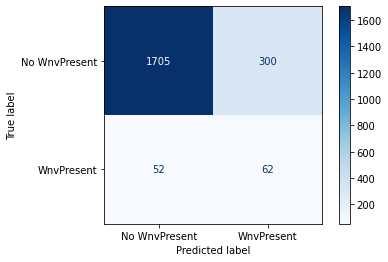

In [38]:
# Plot Confusion matrix
plot_confusion_matrix(rfc_smote_pipe, X_test_sc, y_test, cmap='Blues', 
                      values_format='d', display_labels=['No WnvPresent', 'WnvPresent']);                 

In [39]:
summary_df.loc[2] = ["RandomForestClassifier",
                     "SMOTE",
                     round(train_acc, 3),
                     round(cross_val_acc, 3),
                     round(test_acc, 3),
                     round(train_acc-test_acc, 3),
                     round(sensitivity, 3),
                     round(specificity, 3),
                     round(precision, 3),
                     round(roc_auc, 3),
                    ]

summary_df

,Classifier,Class Balancing Technique,Train Accuracy,GridSearchCV Accuracy,Actual Test Accuracy,Overfit (-ve) / Underfit (+ve),Sensitivity,Specificity,Precision,ROC-AUC
1,LogisticRegression,SMOTE,0.838,0.821,0.802,0.036,0.781,0.664,0.117,0.802
2,RandomForestClassifier,SMOTE,0.888,0.863,0.834,0.054,0.544,0.850,0.171,0.830


After tuning `RandomForestClassifier with Smote`, we can see that the accuracy and ROC-AUC is better than `LogisticRegression`. 

However, sensitivity will be hard to tune upwards while maintaining high precision and ROC_AUC. This might not be good to use if we want to prevent an outbreak if almost half was wrongly predicted to not contain Wnv. We will proceed to tune hyperparameter class weight for the RandomForestClassifier. 

### Random Forest Classifier & Hyperparameter class_weight = `balance_subsample`

We will be manually tuning the parameters as GridsearchCV will only optimise the model based on one scoring parameter. There is a need to find a balance between multiple matrix like accuracy, sensitivity, specifity, precision and ROC_AUC. 


In [222]:
rfs_hyperparam_bal =  RandomForestClassifier(
        n_estimators=1500,
        ccp_alpha=0,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=5,
        random_state=42,
        class_weight='balanced_subsample')

In [223]:
# Fitting X_train_sc and y_train on RandomForestClassifier object defined above.

rfs_hyperparam_bal.fit(X_train_sc, y_train)

RandomForestClassifier(ccp_alpha=0, class_weight='balanced_subsample',
                       max_depth=10, min_samples_leaf=5, min_samples_split=5,
                       n_estimators=1500, random_state=42)

In [224]:
# # Establishing ranges of hyperparameters for GridSearchCV

# pipe_rfs_hyperparam_bal = {
#     'randomforestclassifier__n_estimators': [100,200,300],
#     'randomforestclassifier__max_depth': [5,6],
#     'randomforestclassifier__max_features': ['sqrt','log2',None],
#     'randomforestclassifier__min_samples_split': [4,5],
#     'randomforestclassifier__min_samples_leaf': [2,3,4] 
#     }

In [225]:
# # Creating a GridSearchCV with scoring of ROC_AUC with Randomforest

# gs_rfs_hyperparam_bal = GridSearchCV(rfs_hyperparam_bal, 
#                         param_grid=pipe_rfs_hyperparam_bal, 
#                         cv=5, 
#                         scoring='roc_auc',
#                         n_jobs = -1
#                        )

In [226]:
# Fitting GridSearchCV with Random Forest Classifier

rfs_hyperparam_bal.fit(X_train_sc, y_train)

RandomForestClassifier(ccp_alpha=0, class_weight='balanced_subsample',
                       max_depth=10, min_samples_leaf=5, min_samples_split=5,
                       n_estimators=1500, random_state=42)

In [227]:
# # Best params for rfs with SMOTE
# gs_rfs_hyperparam_bal.best_params_

In [229]:
# Scoring model for all matrix 

train_acc = rfs_hyperparam_bal.score(X_train_sc, y_train)
cross_val_acc = cross_val_score(rfs_hyperparam_bal,X_train_sc,y_train, cv = 5).mean()
test_acc = rfs_hyperparam_bal.score(X_test_sc, y_test)
preds = rfs_hyperparam_bal.predict(X_test_sc)
y_pred_proba = rfs_hyperparam_bal.predict_proba(X_test_sc)

confusion_matrix(y_test, # True values.
                 preds)# Predicted values.
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel();

sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)
roc_auc  = roc_auc_score(y_test, y_pred_proba[:,1])


C:\Users\Admin\.conda\envs\myenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


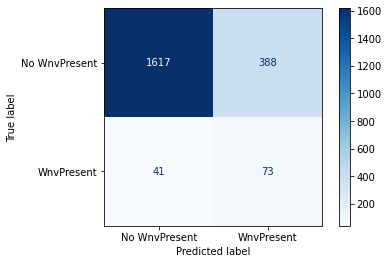

In [230]:
# Plot Confusion matrix
plot_confusion_matrix(rfs_hyperparam_bal, X_test_sc, y_test, cmap='Blues', 
                      values_format='d', display_labels=['No WnvPresent', 'WnvPresent']);                 

In [231]:
summary_df.loc[3] = ["RandomForestClassifier",
                     "Hyperparameter: Balanced Subsample",
                     round(train_acc, 3),
                     round(cross_val_acc, 3),
                     round(test_acc, 3),
                     round(train_acc-test_acc, 3),
                     round(sensitivity, 3),
                     round(specificity, 3),
                     round(precision, 3),
                     round(roc_auc, 3),
                    ]

summary_df

,Classifier,Class Balancing Technique,Train Accuracy,GridSearchCV Accuracy,Actual Test Accuracy,Overfit (-ve) / Underfit (+ve),Sensitivity,Specificity,Precision,ROC-AUC
1,LogisticRegression,SMOTE,0.838,0.821,0.802,0.036,0.781,0.664,0.117,0.802
2,RandomForestClassifier,SMOTE,0.888,0.863,0.834,0.054,0.544,0.850,0.171,0.830
3,RandomForestClassifier,Hyperparameter: Balanced Subsample,0.825,0.814,0.798,0.028,0.640,0.806,0.158,0.833


This hyperparameter tuning enables RandomForestClassifier to handle unbalanced dataset without using the oversampling method, SMOTE. Although the test accuracy suffers a little, the sensitivity and ROC_AUC improved. 

### SVC & SMOTE

In [232]:
# svc_smote_pipe = make_pipeline(
#     # SMOTE(random_state=42),
#     SVC(C=21,
#         kernel='rbf',
#         probability=True, 
#         random_state=42,
#         class_weight = 'balanced',
#         gamma = 'scale',
#         tol = 1e-3
# ))

In [255]:
# Creating a pipeline object using imblearn.pipeline with SMOTE and SVC.

svc_smote_pipe = make_pipeline(
    SMOTE(random_state=42),
    SVC(
        kernel='rbf',
        probability=True, 
        random_state=42,
        class_weight = 'balanced',
        gamma = 'scale',
        tol = 1e-3
))

In [256]:
svc_smote_pipe.get_params()

{'memory': None,
 'steps': [('smote', SMOTE(random_state=42)),
  ('svc', SVC(class_weight='balanced', probability=True, random_state=42))],
 'verbose': False,
 'smote': SMOTE(random_state=42),
 'svc': SVC(class_weight='balanced', probability=True, random_state=42),
 'smote__k_neighbors': 5,
 'smote__n_jobs': None,
 'smote__random_state': 42,
 'smote__sampling_strategy': 'auto',
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': 'balanced',
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': True,
 'svc__random_state': 42,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

In [257]:
# # Fitting X_train_sc and y_train on the pipeline object defined above.

# svc_smote_pipe.fit(X_train_sc, y_train)

In [258]:
# # pipe_svc = {
#     'svc__C': 0.5
#     }

In [261]:
# Establishing ranges of hyperparameters for GridSearchCV

pipe_svc = {
    'svc__C': [0.5]
    }

In [262]:
# Creating a GridSearchCV with scoring of ROC_AUC with Randomforest

gs_svc = GridSearchCV(svc_smote_pipe, 
                        param_grid=pipe_svc, 
                        cv=5, 
                        scoring='roc_auc',
                        n_jobs = -1,
                       )

In [263]:
# Fitting GridSearchCV with Random Forest Classifier

gs_svc.fit(X_train_sc, y_train);

In [264]:
gs_svc.best_params_

{'svc__C': 0.5}

In [265]:
# Scoring model for all matrix 

train_acc = gs_svc.score(X_train_sc, y_train)
cross_val_acc = gs_svc.best_score_
test_acc = gs_svc.score(X_test_sc, y_test)
preds = gs_svc.predict(X_test_sc)
y_pred_proba = gs_svc.predict_proba(X_test_sc)

confusion_matrix(y_test, # True values.
                 preds)# Predicted values.
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel();

sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)
roc_auc  = roc_auc_score(y_test, y_pred_proba[:,1])


C:\Users\Admin\.conda\envs\myenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


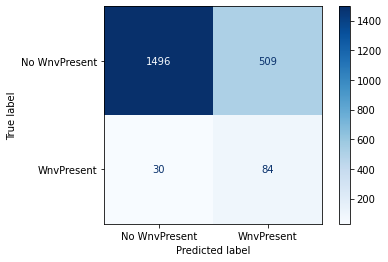

In [266]:
# Plot Confusion matrix
plot_confusion_matrix(gs_svc, X_test_sc, y_test, cmap='Blues', 
                      values_format='d', display_labels=['No WnvPresent', 'WnvPresent']);                 

In [267]:
summary_df.loc[4] = ["SVC",
                     "Hyperparameter: Balanced",
                     round(train_acc, 3),
                     round(cross_val_acc, 3),
                     round(test_acc, 3),
                     round(train_acc-test_acc, 3),
                     round(sensitivity, 3),
                     round(specificity, 3),
                     round(precision, 3),
                     round(roc_auc, 3),
                    ]

summary_df

,Classifier,Class Balancing Technique,Train Accuracy,GridSearchCV Accuracy,Actual Test Accuracy,Overfit (-ve) / Underfit (+ve),Sensitivity,Specificity,Precision,ROC-AUC
1,LogisticRegression,SMOTE,0.838,0.821,0.802,0.036,0.781,0.664,0.117,0.802
2,RandomForestClassifier,SMOTE,0.888,0.863,0.834,0.054,0.544,0.850,0.171,0.830
3,RandomForestClassifier,Hyperparameter: Balanced Subsample,0.825,0.814,0.798,0.028,0.640,0.806,0.158,0.833
4,SVC,Hyperparameter: Balanced,0.893,0.833,0.805,0.088,0.737,0.746,0.142,0.805
5,XGBoost,Hyperparameter: Scale_pos_weight,0.677,0.814,0.663,0.015,0.886,0.650,0.126,0.845


### XGBoost & Hyperparameter tuned: `Scale_pos_weight`

In [268]:
# xbg_model = XGBClassifier(
#     objective = 'binary:logistic',
#     booster = 'dart',
#     learning_rate = 0.1
# )


# xbg_model = XGBClassifier( 
#     scale_pos_weight=30,
#     learning_rate=0.005,  
#     colsample_bytree = 0.6,
#     subsample = 0.59,
#     objective='binary:logistic', 
#     n_estimators=1120, 
#     reg_alpha = 0.1,
#     max_depth=6, 
#     gamma=10,
# )


In [272]:
import xgboost
xgboost.XGBClassifier()

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)

In [459]:
# fit XGBoost on training data

xbg_model = XGBClassifier(
    scale_pos_weight=100,
    learning_rate=0.001,  
    colsample_bytree = 0.4,
    subsample = 0.9,
    objective='binary:logistic',
    booster = 'dart',
    n_estimators=2000, 
    reg_alpha = 0.35,
    max_depth=40, 
    gamma=5,
    min_child_weight = 3
)

                      
eval_set = [(X_test_sc,y_test)]


# use AUC as eval matric
xbg_model.fit(
    X_train_sc,
    y_train,
    early_stopping_rounds=10,
    eval_set=eval_set,
    verbose = False,
    eval_metric='auc'
)

C:\Users\Admin\.conda\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4,
              enable_categorical=False, gamma=5, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=40,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=6, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0.35, reg_lambda=1,
              scale_pos_weight=100, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [460]:
# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=X_train_sc,label=y_train)

params = {
    "objective":"binary:logistic",  
    'scale_pos_weight':100,
    'learning_rate':0.001,  
    'colsample_bytree' : 0.4,
    'subsample' : 0.9,
    'booster' : 'dart',
    'reg_alpha' : 0.35,
    'max_depth':40, 
    'gamma':5,
}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics = 'logloss', as_pandas=True, seed=42)

In [461]:
# Scoring model for all matrix 

train_acc = xbg_model.score(X_train_sc, y_train)
cross_val_acc = xgb_cv.mean()[0]
test_acc = xbg_model.score(X_test_sc, y_test)
preds = xbg_model.predict(X_test_sc)
y_pred_proba = xbg_model.predict_proba(X_test_sc)

confusion_matrix(y_test, # True values.
                 preds)# Predicted values.
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel();

sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)
roc_auc  = roc_auc_score(y_test, y_pred_proba[:,1])


C:\Users\Admin\.conda\envs\myenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


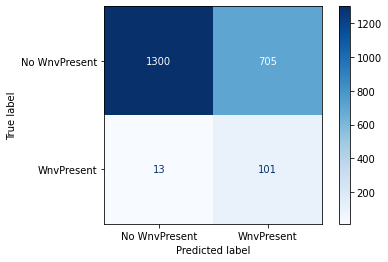

In [462]:
# Plot Confusion matrix
plot_confusion_matrix(xbg_model, X_test_sc, y_test, cmap='Blues', 
                      values_format='d', display_labels=['No WnvPresent', 'WnvPresent']);                 

In [463]:
summary_df.loc[5] = ["XGBoost",
                    'Hyperparameter: Scale_pos_weight',
                     round(train_acc, 3),
                     round(cross_val_acc, 3),
                     round(test_acc, 3),
                     round(train_acc-test_acc, 3),
                     round(sensitivity, 3),
                     round(specificity, 3),
                     round(precision, 3),
                     round(roc_auc, 3),
                    ]

summary_df

,Classifier,Class Balancing Technique,Train Accuracy,GridSearchCV Accuracy,Actual Test Accuracy,Overfit (-ve) / Underfit (+ve),Sensitivity,Specificity,Precision,ROC-AUC
1,LogisticRegression,SMOTE,0.838,0.821,0.802,0.036,0.781,0.664,0.117,0.802
2,RandomForestClassifier,SMOTE,0.888,0.863,0.834,0.054,0.544,0.850,0.171,0.830
3,RandomForestClassifier,Hyperparameter: Balanced Subsample,0.825,0.814,0.798,0.028,0.640,0.806,0.158,0.833
4,SVC,Hyperparameter: Balanced,0.893,0.833,0.805,0.088,0.737,0.746,0.142,0.805
5,XGBoost,Hyperparameter: Scale_pos_weight,0.677,0.682,0.661,0.016,0.886,0.648,0.125,0.846


`XGBoost` has the `highest ROC_AUC and sensitivity scores` compared to the other models. Although it suffers from the train accuracies, it is relatively better fitted, achieving the best balance between bias and variance, allowing the model to predict well with unseen data. Although it has the a low precision, the priority is to strongly predict true wnv containing places in order to prevent a huge outbreak that may cause further monetary damage than just spending on spraying. Like they say, better be safe than sorry.  

# Feature importance

In [464]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(15,15))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

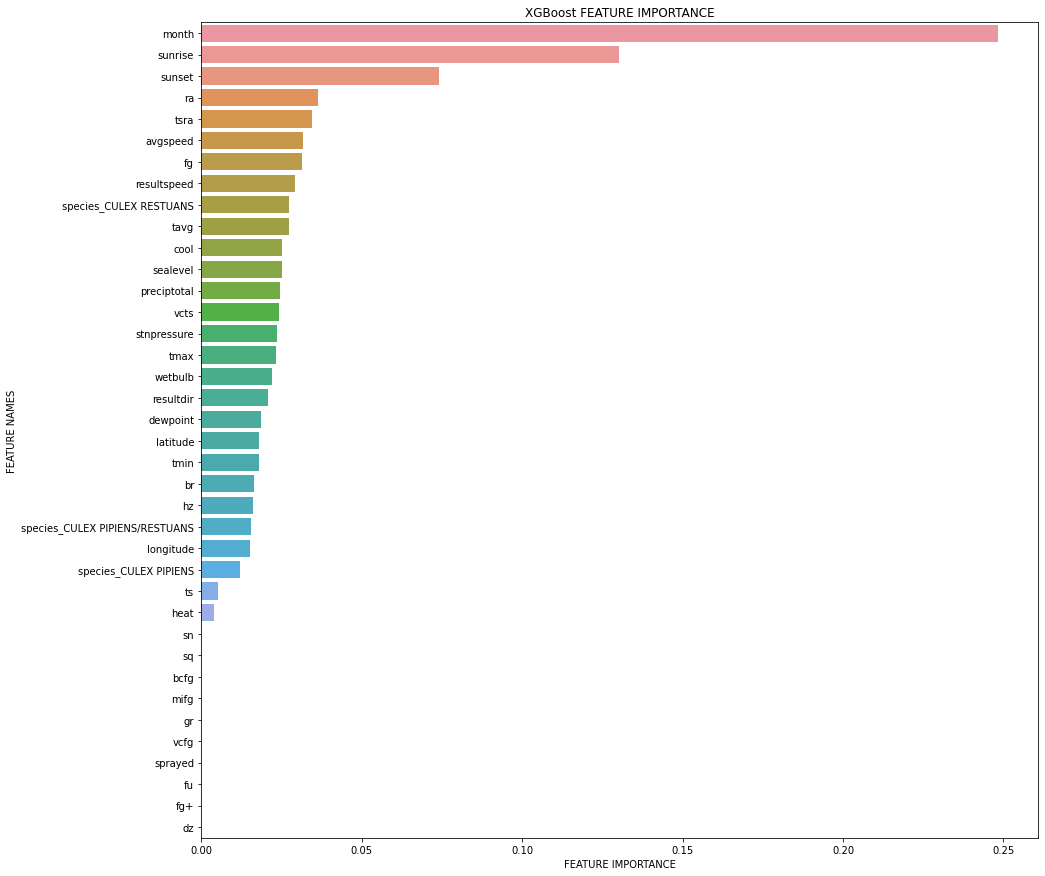

In [465]:
plot_feature_importance(xbg_model.feature_importances_,X.columns,'XGBoost')

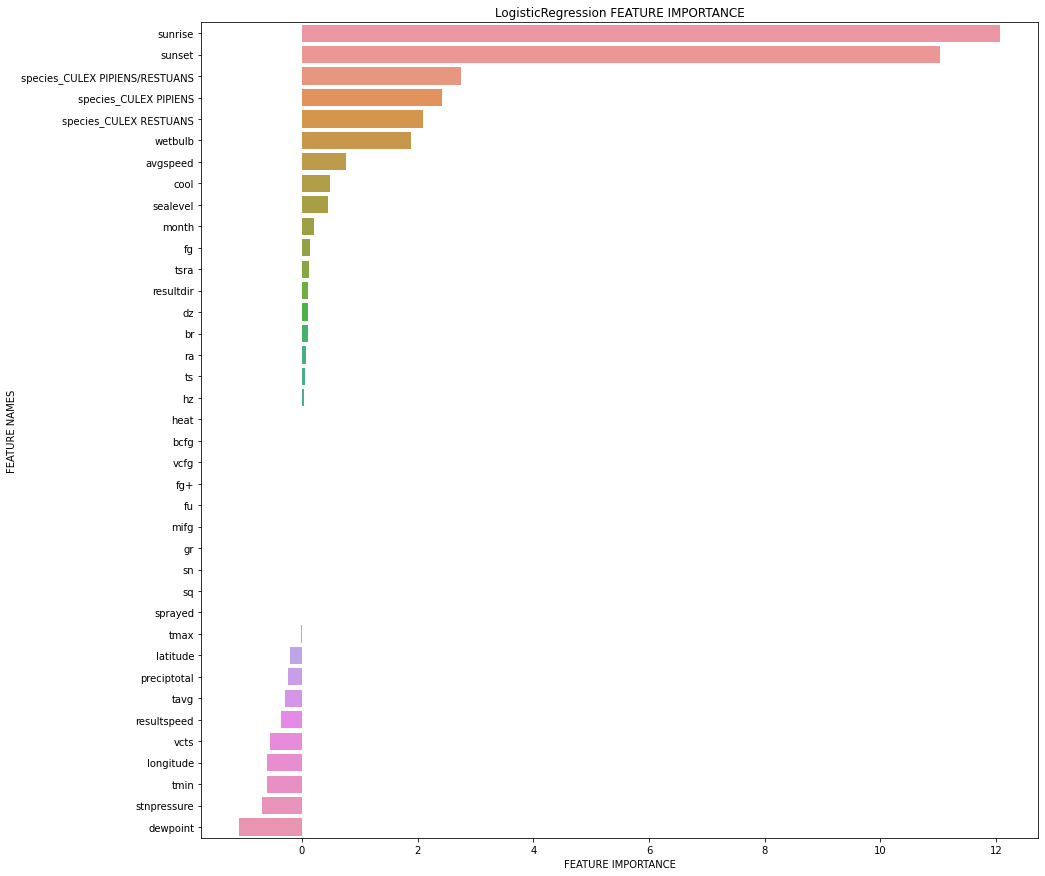

In [466]:
plot_feature_importance(gs_logreg.best_estimator_[1].coef_.reshape(38,),X.columns,'LogisticRegression')

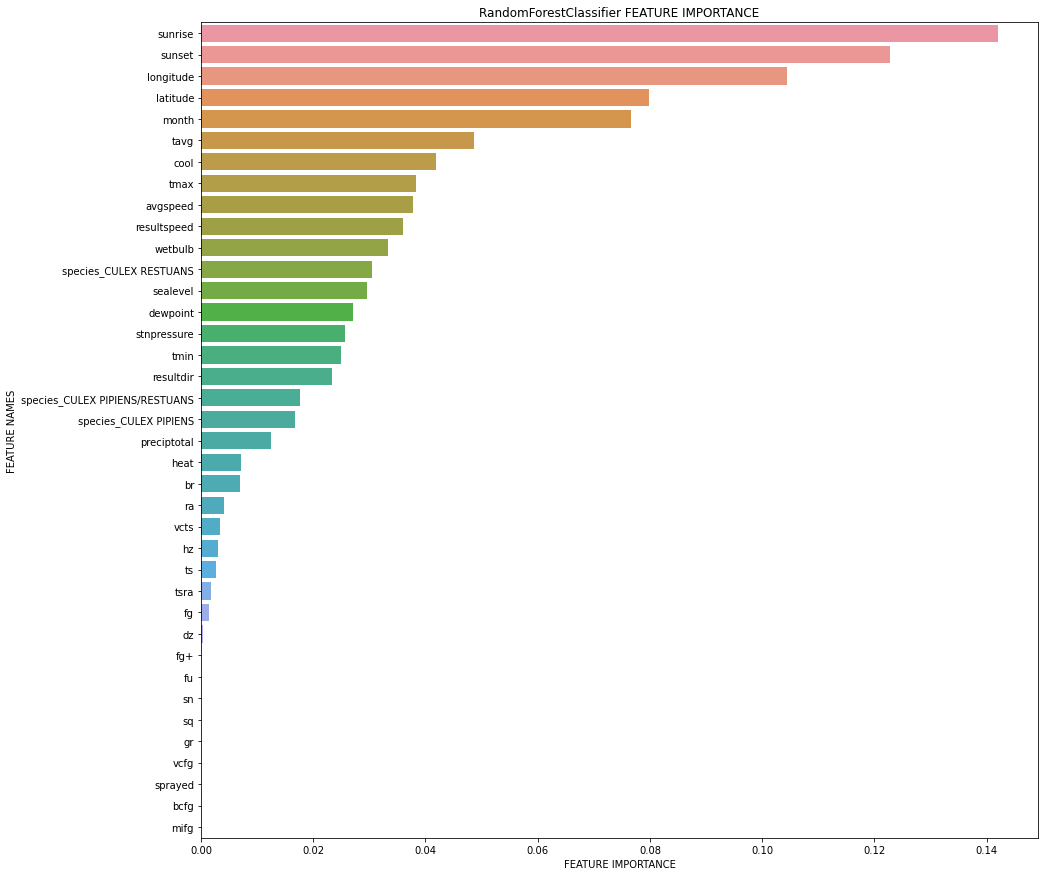

In [467]:
plot_feature_importance(rfs_hyperparam_bal.feature_importances_,X.columns,'RandomForestClassifier')

# ROC Curve

C:\Users\Admin\.conda\envs\myenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


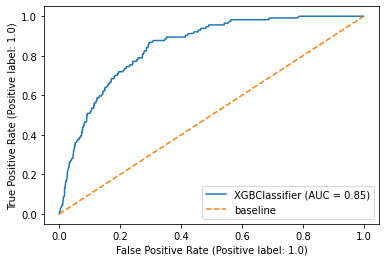

In [468]:

plot_roc_curve(xbg_model, X_test_sc, y_test)

plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

# Cost Benefit Analysis

# Kaggle Submission